# Import Problem Instance
We start by importing a simple problem instance to demonstrate the tsplib reader.


In [1]:
from tsplib95 import tsplib95
import itertools
import networkx as nx

instance = tsplib95.load_problem('./tsplib/ulysses16.tsp')

instance.comment

'Odyssey of Ulysses (Groetschel/Padberg)'

Remember, this repository contains a small selection of TSP instances that you can use to test your algorithms.

| name | nodes | description |
|------|-------|-------------|
| ulysses16.tsp | 16 | Odyssey of Ulysses |
| ulysses7.tsp | 7 | subset of ulysses16 for testing purposes |
| bayg29.tsp | 29 | 29 Cities in Bavaria |
| bier127.tsp | 127 | 127 Biergaerten in Augsburg |
| bier20.tsp | 20 | subset of bier127 |
| brazil58.tsp | 58 | 58 cities in Brazil |
| ali535.tsp | 535 | 535 Airports around the globe |
| d18512.tsp | 18512 | 18512 places in Germany |

The following calls show the dimension = number of nodes of the problem, its node set and the edge weights. The functions `instance.get_nodes()` and `instance.get_edges()` are implemented as iterators, so you can loop over the nodes or edges. To get a list of nodes or edges, you have to explicitly construct one using `list(instance.get_nodes())`. Note that node counting may start at 1 for some instances while others use 0 as starting point. For convenience, we store the index of the first node as `first_node`.


In [2]:
instance.dimension

instance.get_nodes()
print("List of nodes: ", list(instance.get_nodes()))

first_node = min(instance.get_nodes())
first_node

for i,j in instance.get_edges():
    if i >= j:
        continue
    print(f"edge {{ {i:2},{j:2} }} has weight {instance.wfunc(i,j):3}.")


List of nodes:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
edge {  1, 2 } has weight   6.
edge {  1, 3 } has weight   5.
edge {  1, 4 } has weight   3.
edge {  1, 5 } has weight  11.
edge {  1, 6 } has weight   8.
edge {  1, 7 } has weight   7.
edge {  1, 8 } has weight   1.
edge {  1, 9 } has weight  12.
edge {  1,10 } has weight   8.
edge {  1,11 } has weight  26.
edge {  1,12 } has weight   5.
edge {  1,13 } has weight   5.
edge {  1,14 } has weight   5.
edge {  1,15 } has weight   7.
edge {  1,16 } has weight   1.
edge {  2, 3 } has weight   1.
edge {  2, 4 } has weight   4.
edge {  2, 5 } has weight  17.
edge {  2, 6 } has weight  14.
edge {  2, 7 } has weight  13.
edge {  2, 8 } has weight   6.
edge {  2, 9 } has weight  17.
edge {  2,10 } has weight  13.
edge {  2,11 } has weight  32.
edge {  2,12 } has weight  11.
edge {  2,13 } has weight  11.
edge {  2,14 } has weight  11.
edge {  2,15 } has weight  13.
edge {  2,16 } has weight   7.
edge {  3, 4 } has weight   5

You have already seen how to draw a graph, here is the relevant code again.

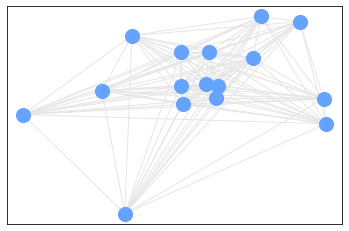

In [4]:
G = instance.get_graph()
if instance.is_depictable():
    pos = {i: instance.get_display(i) for i in instance.get_nodes()}
else:
    pos = nx.drawing.layout.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='#66a3ff', node_size=200)
#nx.draw_networkx_labels(G, pos, font_weight='bold' )
nx.draw_networkx_edges(G, pos,  edge_color='#e6e6e6')

# Implementing the MTZ model in Gurobi
We will implement the Miller-Tucker-Zemlin formulation using binary variables $x_{ij} \in \{0,1\}$ to indicate whether arc $(i,j)$ is being used in the tour and variables $y_i \ge 0$ as "position variables" for each node $i \in V$. The formulation looks like this:

\begin{align}
\min\;&\sum_{i,j \in V; i \ne j} c_{i,j} \cdot x_{i,j}\\
&\sum_{j \ne i} x_{i,j} = 1 \quad \text{for all nodes $i$}\\
&\sum_{j \ne i} x_{j,i} = 1 \quad \text{for all nodes $i$}\\
&y_1 = 1\\
&y_i \le n \quad \text{for all nodes $i \ne v_0$}\\
&y_i \ge 2 \quad \text{for all nodes $i \ne v_0$}\\
&y_i - y_j + (n-1) \cdot x_{i,j} \le n-2 \quad \text{for all nodes $i,j$ with $i,j \ne 1$ and $i \ne j$}\\
&x_{i,j} \in \{0,1\}\\
&y_i \ge 0
\end{align}

## Creating the variables
We start by creating the model and the variables. Notice that we already define the objective function by using the `obj` parameter upon variable creation. For demonstration purposes, we use a loop for defining the $x$ variables and a shortcut function for the $y$ variables. Note that the assumption $y_i \ge 0$ is implicit.

In [9]:
import gurobipy as grb

# create a new model
model = grb.Model(name="MTZ TSP formulation")

# create dictionary with tupel as keys 
# elements of x can then be accesses via x[i,j]
x = grb.tupledict()
# filter discards all elements that do not fit the filter criteria
for i,j in filter(lambda e: e[0] != e[1], instance.get_edges()): 
    # add variable with objective coefficient obj, type {0,1} (binary)
    x[i,j] = model.addVar(obj=instance.wfunc(i,j), vtype=grb.GRB.BINARY, name=f"x[{i},{j}]")

# add variable for every element of instance.get_nodes()
y = model.addVars(instance.get_nodes(), name="y")

## Adding the constraints
Next, we add the constraints for our model. Notice that $y_i \ge 0$ is implicit and $x_{i,j} \in \{0,1\}$ has been included in the variable definition already. We start with the simple constraints on the $y_i$ variables. Notice that we could also have used methods to set lower and upper bounds for the $y_i$ for most of the simple constraints.


In [12]:
model.addConstr(y[first_node] == 1)
for i in itertools.islice(instance.get_nodes(),first_node+1,None):
    model.addConstr(y[i] <= instance.dimension)

**Task 1:** Add another loop to formulate the constraints $y_i \ge 2$ for all nodes $i \ne v_0$.

In [ ]:
for i in itertools.islice(instance.get_nodes(),first_node+1,None):
    model.addConstr(y[i] >= 2)

The remaining constraints require iteration over all edges. We use the keys() set of our variables for this purpose to ensure we only iterate over edges that are actually defined.

In [13]:
for i,j in filter(lambda e: e[0] != e[1] and e[0] != first_node and e[1] != first_node, x.keys()):
    model.addConstr(y[i] - y[j] + (instance.dimension-1)*x[i,j] <= (instance.dimension-2))

**Task 2:** Add the in- and out-degree constraints
\begin{align}
&\sum_{j \ne i} x_{i,j} = 1 \quad \text{for all nodes $i$}\\
&\sum_{j \ne i} x_{j,i} = 1 \quad \text{for all nodes $i$}\\
\end{align}

In [ ]:
for i in instance.get_nodes():
    model.addConstr(sum(x[i,j] for j in instance.get_nodes() if j != i) == 1)
    model.addConstr(sum(x[j,i] for j in instance.get_nodes() if j != i) == 1)

## Starting the Optimization Process
Finally, we set the objective to minimization and call the optimizer.

In [14]:
model.ModelSense = grb.GRB.MINIMIZE
model.optimize()

Optimize a model with 240 rows, 256 columns and 660 nonzeros
Variable types: 16 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


## Querying and Visualizing the Solution
Before we visualize our result, let us look at a few key figures of our solution.

In [17]:
print(f"Objective value: {model.ObjVal}")
print(f"value of x variables: {model.x}")

solution_edges = [(i,j) for i,j in x.keys() if x[i,j].x > 0.9]
solution_edges


Objective value: 0.0
value of x variables: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

[]

For debugging purposes, it might be helpful to export the model held by Gurobi into a human-readable format:

In [20]:
model.write('test.lp')

 Finally, let us visualize the solution using NetworkX. In this case, we need to prescribe positions and draw the nodes and two layers of edges separately.

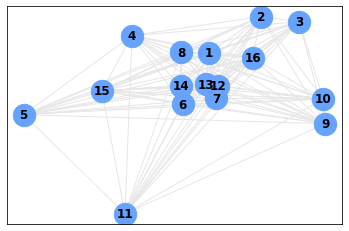

In [23]:
if instance.is_depictable():
    pos = {i: instance.get_display(i) for i in instance.get_nodes()}
else:
    pos = nx.drawing.layout.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='#66a3ff', node_size=500)
nx.draw_networkx_labels(G, pos, font_weight='bold' )
nx.draw_networkx_edges(G, pos,  edge_color='#e6e6e6')
nx.draw_networkx_edges(G, pos,  edgelist=solution_edges, edge_color='#ffa31a', width=4)